In [1]:
# This program is to form the data into pkl file
# Basic setting
# # import package
import h5py
import numpy as np
import netCDF4 as nc

In [2]:


# ==================== #
# main function
def main():
    # load data
    pr_list = np.array([0, 10, 20, 30, 40, 50]) # candidate to load

    # design coordinate
    lat = np.linspace(-90, 90, 64)
    lon = np.linspace(0, 360, 129)[:-1]
    time = np.linspace(0, 78000, 78000)
    # time = np.linspace(0, 78000/4-1, 78000)
    

    cond = np.where((lat>=-15)&(lat<=15))[0]

    print(cond)
    # # load data
    for pr in pr_list:
        with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/prec/PR{pr}_500_20000day_6hourly_prec_0_600hPa_sum.nc"
                       
                ) as f:
            prec_data = np.array(f["prec"][:, cond, :])
        
        # with nc.Dataset(f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/prec_pr{pr}.nc", "w") as f:
        with nc.Dataset(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/PowerSpec_Dycore/data/pr{pr}/prec_pr{pr}_0_600hPa_sum.nc", "w") as f:
            
            
            lon_dim = f.createDimension("lon", 128)
            lat_dim = f.createDimension("lat", len(cond))
            time_dim = f.createDimension("time", 78000)

            lon_var = f.createVariable("lon", np.float64, ("lon",))
            lon_var[:] = lon

            lat_var = f.createVariable("lat", np.float64, ("lat",))
            lat_var[:] = lat[cond]

            time_var = f.createVariable("time", np.float64, ("time",))
            time_var[:] = time

            prec0 = f.createVariable("prec", np.float64, ("time", "lat", "lon"))
            prec0[:] = prec_data

        print(f"PR {pr} finished")

# ==================== #
# execution section
if __name__ == "__main__":
    main()


[27 28 29 30 31 32 33 34 35 36]
PR 0 finished
PR 10 finished
PR 20 finished
PR 30 finished
PR 40 finished
PR 50 finished


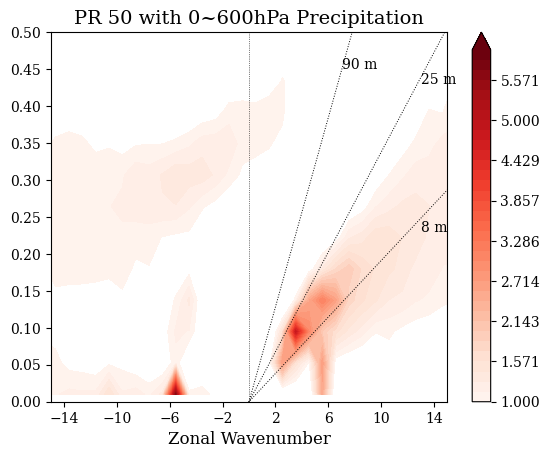

In [427]:
#######################################################################################
import sys
import h5py
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

sys.path.append("/home/b11209013/Package/")
import Theory as th 
import DataProcess as dp
import SignalProcess as sp

plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["font.family"] = "serif"

# ================== #
# functions
# Gaussian filter
def background(sym, asy, cr=10):
    ave = (sym + asy) / 2

    low = dp.GaussianFilter(ave[:cr], 40)
    high = dp.GaussianFilter(ave[cr:], 10)

    space_filt = np.concatenate([low, high], axis=0).T

    bg = dp.GaussianFilter(space_filt, 10).T

    return bg

# ============================= #
def main(PR):
    # Load data
    lat = np.linspace(-90, 90, 64)

    cond = np.where((lat >= -15) & (lat <= 15))[0]
    lat = lat[cond]

    # Load precipitation data
    with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_600hPa_sum.dat") as f:
        prec = f["prec"][:, cond, :]

    prec = prec - prec.mean()  # Remove the mean

    # Apply Hanning window to reduce edge effects
    window = np.hanning(prec.shape[1])[:, None] * np.hanning(prec.shape[2])
    prec_windowed = prec * window

    # ============================== #
    
    # FFT with windowing
    prec_fft = np.array([
        np.fft.fftshift(np.fft.fft2(prec_windowed[:, i, :]))[:, ::-1]
        for i in range(len(lat))
    ])

    # ============================== #
    
    # Split data into segments
    split = np.array([prec[i * 36:i * 36 + 96] for i in range(2165)])

    # Format data for symmetry and asymmetry
    fmt = dp.Format(lat)
    
    sym_split = np.array([fmt.sym(split[i]) for i in range(split.shape[0])])
    asy_split = np.array([fmt.asy(split[i]) for i in range(split.shape[0])])

    # ============================== #
    
    # Power Spectrum
    ft = sp.Fourier()
    
    sym_ps = np.array([ft.PowerSpectrum(sym_split[i]) for i in range(2165)]).mean(axis=0)
    asy_ps = np.array([ft.PowerSpectrum(asy_split[i]) for i in range(2165)]).mean(axis=0)

    # =============================== #
    
    # Peak computation
    bg = background(sym_ps, asy_ps, 15)
    sym_peak = sym_ps / bg 

    # =============================== #
    
    # Plot Power Spectrum
    
    wn = np.linspace(-64, 64, 128)
    fr = np.linspace(1 / 96, 2, 48)
    
    wnm, frm = np.meshgrid(wn, fr)
 
    Kelvin8 = th.Wave(wn, 8)
    Kelvin25 = th.Wave(wn, 25)
    Kelvin90 = th.Wave(wn, 90)
    
    plt.contourf(
        wnm,
        frm,
        sym_peak,
        cmap="Reds",
        levels=np.linspace(1, 6, 36),
        extend="max",
    )
    plt.plot(
        wn, Kelvin8.Kelvin(), color="black", linestyle=":", linewidth=0.7
    )
    plt.plot(
        wn, Kelvin25.Kelvin(), color="black", linestyle=":", linewidth=0.7
    )
    plt.plot(
        wn, Kelvin90.Kelvin(), color="black", linestyle=":", linewidth=0.7
    )
    plt.text(7, 0.45, "90 m", fontsize=10)
    plt.text(13, 0.43, "25 m", fontsize=10)
    plt.text(13, 0.23, "8 m", fontsize=10)
    plt.axvline(0, color="black", linewidth=0.5, linestyle=":")
    plt.xticks(np.linspace(-14, 14, 8))
    plt.yticks(np.linspace(0, 0.5, 11))
    plt.xlim(-15, 15)
    plt.ylim(0, 1 / 2)
    plt.xlabel("Zonal Wavenumber")
    plt.title(f"PR {PR} with 0~600hPa Precipitation")
    plt.colorbar()

    plt.show()
    

if __name__ == "__main__":
    PR = 50
    main(PR)


In [18]:
# This program is to reconstruct the signal of the signal of Kelvin waves
# Basic Settring 
# # import package
import sys
import h5py
import numpy as np

from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter 

from matplotlib import colors as cm
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm


sys.path.append("/home/b11209013/Package/")
import Theory as th

# ================== #
# functions
# # plot setting
def plot_setting():
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10
    plt.rcParams["font.family"] = "serif"

# ================== #
# main function
def main(PR):
    # load data
    path:str = f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/pr{PR}/"

    # # range latitude
    lat = np.linspace(-90, 90, 64)
    
    lat_cond = np.where((lat>=-30)&(lat<=30))[0]
    lat = lat[lat_cond]
    print(lat_cond)
    # prec data
    # with h5py.File(path+"prec_pr50.dat") as f:
    with h5py.File(f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_600hPa_sum.dat"
) as f:
        prec = f["prec"][:, lat_cond]
    prec -= prec.mean(axis=0)
    prec *= 86400
    
    # pressure data
    # pressure_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR50/p/PR50_500_20000day_6hourly_p.dat"
    # with h5py.File(pressure_path) as f:
    #     # print(f.keys())
    #     p = f["p"][:, 7, lat_cond]
    # p -= p.mean(axis=0)
    
    # u-wind
    # with h5py.File(path+"u_pr50.dat") as f:
    #     u = f["u"][:, 5, lat_cond]

    # u -= u.mean(axis=0)

    # # v-wind
    # with h5py.File(path+"v_pr50.dat") as f:
    #     v = f["v"][:, 5, lat_cond]

    # v -= v.mean(axis=0)

    # ================= #
    # Reconstruct Kelvin waves
    # # FFT
    # # # precpitation
    prec_fft = np.array([
        np.fft.fftshift(np.fft.fft2(prec[:, i, :]))[:, ::-1]
        for i in range(len(lat_cond))
        ])

    # p_fft = np.array([
    #     np.fft.fftshift(np.fft.fft2(p[:, i, :]))[:, ::-1]
    #     for i in range(len(lat_cond))
    #     ])

    # # # u-wind
    # u_fft = np.array([
    #     np.fft.fftshift(np.fft.fft2(u[:, i, :]))[:, ::-1]
    #     for i in range(len(lat_cond))
    #     ])

    # # # # v-wind
    # v_fft = np.array([
    #     np.fft.fftshift(np.fft.fft2(v[:, i, :]))[:, ::-1]
    #     for i in range(len(lat_cond))
    #     ])


    # # dimension for bandpass filter
    wn = np.linspace(-64, 64, 128)
    fr = np.linspace(-2, 2, 78000)

    wnm, frm = np.meshgrid(wn, fr)
    
    ed8 = th.Wave(wnm, 8)
    ed90 = th.Wave(wnm, 25)

    cond = np.logical_or.reduce([
        wnm < 1, wnm > 4,
        # frm < 0.01, frm > 0.1,
        frm < 0.01, frm > 0.15,     
        frm < ed8.Kelvin(), frm > ed90.Kelvin()
        ])

    # # bandpass filter and inverse FFT
    # # # IFFT
    prec_ifft = []
    # u_ifft = []
    # v_ifft = []
    # p_ifft = []

    for i in range(len(lat_cond)):
        prec_filted = np.where(cond == True, 0, prec_fft[i]*2)
        prec_ifft.append(np.fft.ifft2(np.fft.ifftshift(prec_filted)))


        # u_filted = np.where(cond == True, 0, u_fft[i]*2)
        # u_ifft.append(np.fft.ifft2(np.fft.ifftshift(u_filted)))

        # v_filted = np.where(cond == True, 0, v_fft[i]*2)
        # v_ifft.append(np.fft.ifft2(np.fft.ifftshift(v_filted)))

    # # # reconstruct
    prec_recon = np.real(np.stack(prec_ifft, axis=1))

    return prec_recon
# ===================== #
# execution section
if __name__ == "__main__":
    PR = 50
    prec_recon = main(PR)
    print("done")

#########################################################




[21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
done


In [19]:
yyy = np.linspace(-90,90,64)
print(yyy[21:42][:])

xxx = np.linspace(0,360,128)
print(xxx[55:64])

[-30.         -27.14285714 -24.28571429 -21.42857143 -18.57142857
 -15.71428571 -12.85714286 -10.          -7.14285714  -4.28571429
  -1.42857143   1.42857143   4.28571429   7.14285714  10.
  12.85714286  15.71428571  18.57142857  21.42857143  24.28571429
  27.14285714]
[155.90551181 158.74015748 161.57480315 164.40944882 167.24409449
 170.07874016 172.91338583 175.7480315  178.58267717]


# Precipitation regress on the wind field

In [20]:
prec_recon.shape

(78000, 22, 128)

In [21]:
prec_mean = prec_recon[:, 5:-4, 55:64].mean(axis=(1,2))
prec_mean = prec_mean.reshape([78000,1])
print(prec_mean.T.shape)
#########################################################
# prec_mean = prec_recon[:, 2:-1, 55:64].mean(axis=(1,2))
# prec_mean = prec_mean.reshape([78000,1])
# print(prec_mean.T.shape)

(1, 78000)


In [22]:
test = prec_mean.T.dot(prec_recon.reshape([78000, 22*128])) / (prec_mean.T.dot(prec_mean))
########################################################
# test = prec_mean.T.dot(prec_recon.reshape([78000, 22*128])) / (prec_mean.T.dot(prec_mean))


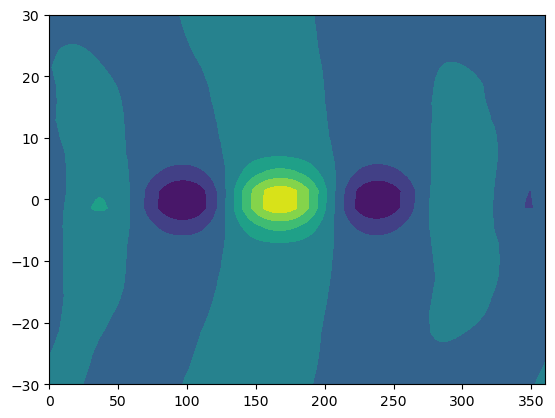

In [23]:
xxx2, yyy2 = np.meshgrid(xxx,yyy)
plt.figure()
plt.contourf(xxx2[21:43, :],yyy2[21:43, :], test.reshape([22, 128]))

In [37]:
# Define the path
PR = 50
path = f"/home/b11209013/2024_Research/PowerSpec_Dycore/data/pr{PR}/"
pressure_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"

    
# Efficiently read the wind data using chunked reading
with h5py.File(path + f"u_pr{PR}.dat", "r") as f_u, h5py.File(path + f"v_pr{PR}.dat", "r") as f_v, h5py.File(pressure_path, "r") as f_p:
    # level_index = 3  # Specific vertical level
    level_index = -3  # Specific vertical level
    
    
    # Read u and v wind fields using chunked reading
    u = f_u["u"][:, level_index, :, :]
    v = f_v["v"][:, level_index, :, :]
    print(f_p.keys())
    p = f_p["dz"][:, level_index, :, :]


# Check the shape of the loaded arrays
print("Shape of u:", u.shape)
print("Shape of v:", v.shape)
print("Shape of p:", p.shape)



<KeysViewHDF5 ['dz']>
Shape of u: (78000, 64, 128)
Shape of v: (78000, 64, 128)
Shape of p: (78000, 64, 128)


In [38]:
time_dim, y_dim, x_dim =  u.shape[0], u.shape[1], u.shape[2]


u_reshape = np.reshape(u, (time_dim, x_dim*y_dim)) # (time, y, x)
v_reshape = np.reshape(v, (time_dim, x_dim*y_dim))
p_reshape = np.reshape(p, (time_dim, x_dim*y_dim))


PC_sel = prec_mean


In [39]:
a = (PC_sel.T.dot(u_reshape)) / (PC_sel.T.dot(PC_sel))  #(x*y, time) * time / ...

In [40]:
b = (PC_sel.T.dot(v_reshape)) / (PC_sel.T.dot(PC_sel))

In [41]:
c = (PC_sel.T.dot(p_reshape)) / (PC_sel.T.dot(PC_sel))


In [42]:
a_reshape = np.reshape(a, (y_dim, x_dim))
b_reshape = np.reshape(b, (y_dim, x_dim))
c_reshape = np.reshape(c, (y_dim, x_dim))



In [43]:
lonm, latm = np.meshgrid(xxx,yyy)

In [44]:
a_final = a_reshape
b_final = b_reshape
c_final = c_reshape



0.1


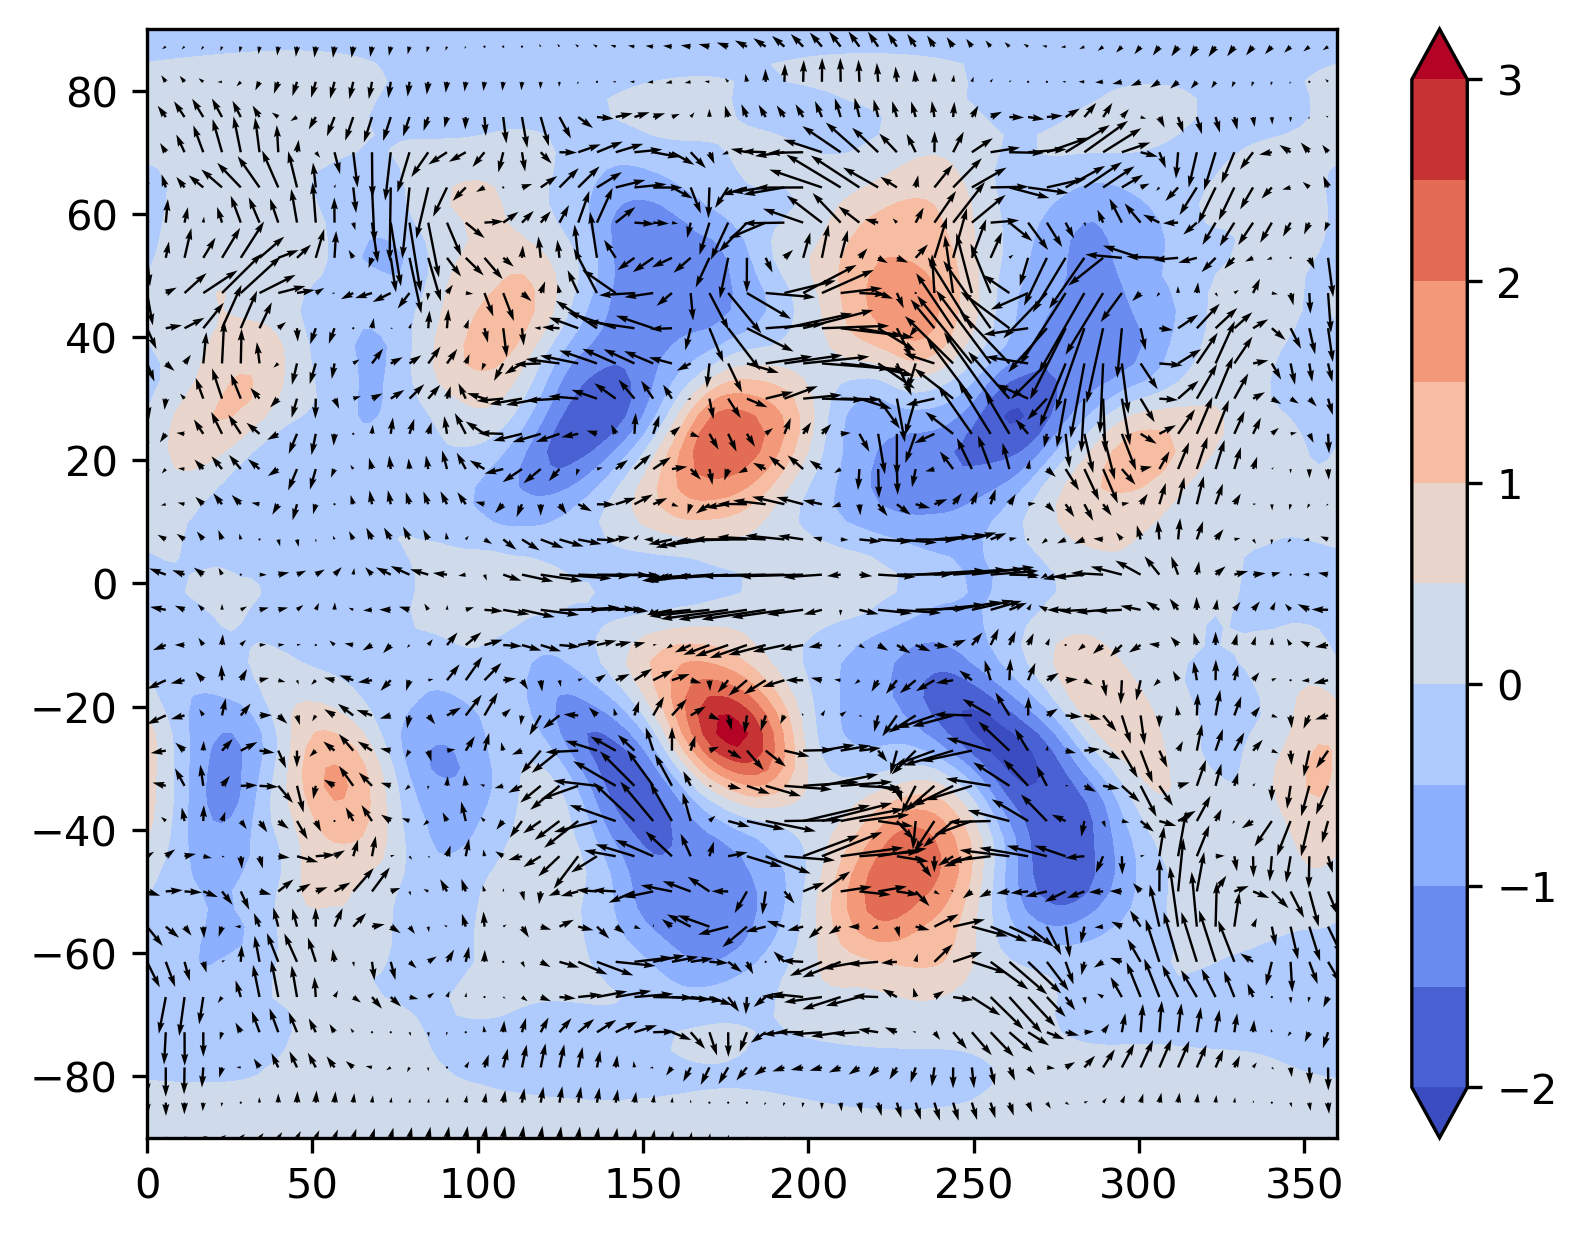

In [50]:
import matplotlib.pyplot as plt
idx = 2
plt.figure(dpi=300.)
CS = plt.contourf(lonm, latm, c_final, cmap="coolwarm", levels=11, extend="both")
plt.colorbar(CS)
#plt.contour(lonm[21:43, :], latm[21:43, :], test.reshape([22, 128]))
q = plt.quiver(lonm[::idx, ::idx], latm[::idx, ::idx], a_final[::idx, ::idx], b_final[::idx, ::idx], color="black", scale_units='xy', angles='xy', width=0.002, scale=0.1)
print(q.scale)

In [81]:
path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_0_6hourly_CC_OK/RH80_PR0_20000day_startfrom_10100day_final.dat"

    
# Efficiently read the wind data using chunked reading
with h5py.File(path, "r") as f_u:    
    print(f_u.keys())
    geo = f_u["grid_z_full_xyzt"][:]

<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_w_full_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>


In [82]:
geo.shape

(100, 20, 64, 128)

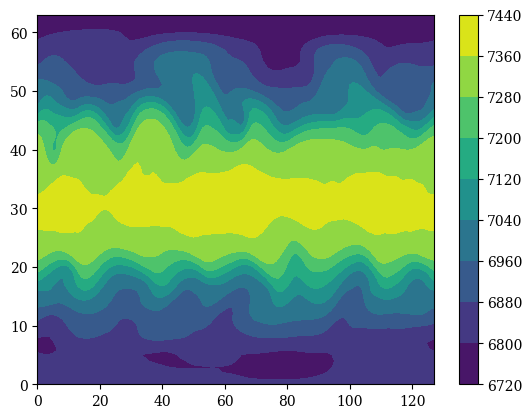

In [467]:
plt.figure()
plt.contourf(geo[3].mean(axis=(0)))
plt.colorbar()

In [76]:
geo.min()

0.0

(78000, 64, 128)